***
$$\mathbf{\text{Simulation/Experimental Output Processing and ML-MF Correction}}$$<br>
$$\mathbf{\text{Author: Kenneth Kusima}}$$<br>
$\mathbf{\text{Date: 06/01}}$<br>

#### Note sw: Switching -> CO<->O2 ; CO*<->O* To match KMC specnum file


#### It also |uses the MKM input files that match this order *_sw

#### As well as the new test set KMC_NonDynamic_Data_iCovg_iRates_sw

#### Switch the pressures accordingly CO <-> O2

***
$\mathbf{\text{Model being explored: Simple 4-step CO Oxidation}}:$<br>

${\text{Corresponding Micro Kinetic Model}}:$<br>
***
$$\require{mhchem}$$       
---
Overall Reaction: 
$$ CO + \frac{1}{2} O_2 {\stackrel{\tiny{\textrm{Pt/Pd}}}{\rightleftharpoons}} CO_2 $$
---
Note Reations in the Reaction Mechanism may be reversible or irreversible

Reaction 1:&emsp;Adsorption of CO

$$ CO + * \rightleftharpoons CO^{*} $$

Reaction 2:&emsp;Adsorption of $O_2$

$$ O_2 + * \rightleftharpoons {O_2}^{*} $$

Reaction 3:&emsp;Dissociation of ${O_2}^*$ 

$$ {O_2}^* + * \rightleftharpoons 2{O}^* $$

Reaction 4:&emsp;Surface Reaction of $CO$ and $O_2$  

$$ {CO}^{*} + {O}^{*} \rightleftharpoons CO_2 + 2* $$

In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

***

<a id="top"></a><br>
 # Table of Contents  
1. [Loading in the labeled simulation folders](#1)   
    1. [Checking all simulations were completed as expected](#1.1)
1. [Developing ML Training Dataset for rate correction](#2) 
    1. [Generating Experimental Data Dictionary](#2.1) 
    1. [Generating MF-MKM Data Dictionary](#2.2)     
    1. [Creating Features](#2.3)      
        C1. [Log ratio](#2.3.1)     
        C2. [Percent Difference](#2.3.2)    
        
    1. [Creating Input/Feature Tensor](#2.4)
    1. [Extracting Full X (Feature) and Y(Target) datasets](#2.5)
    1. [Performing Train/Test X and Y Split datasets](#2.6)
1. [Modelling](#3)
1. [Describing Possible Machine Learning Model Algorithms](#4)
1. [Selecting and Training the Model](#5)
1. [Importing External/Experimental Data to be used in the model](#6)
    1. [Generating corresponding MF-MKModel](#6.1) 
    1. [Predicting Machine-Learned Mean-Field Corrections](#6.2)
    1. [ML Correction to MF-MKModel](#6.3)
    1. [Evaluating the ML model prediction](#6.4)
    1. [Plotting results](#6.5)
    
1. [Exploring and Evaluating possible ML options](#7)

***
<a id="1"></a> 
## 1. Loading in the labeled simulation folders
<a href="#top">Back to top</a>

In [2]:
os.getcwd()

'/Users/klkusima/Library/CloudStorage/OneDrive-UniversityOfHouston/MiKi/Input_data_KMC_Lateral/KMC_output_varied_coverage'

In [3]:
%%time
Sim_folder_names = []
i = 0
for file in glob.glob("Sim_*"):
    Sim_folder_names.append(file)
    i+=1
print('Number of simulations:',i)
print(Sim_folder_names)
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

Number of simulations: 55
['Sim_A_0_B_77', 'Sim_A_44_B_55', 'Sim_A_55_B_22', 'Sim_A_22_B_77', 'Sim_A_88_B_11', 'Sim_A_22_B_22', 'Sim_A_33_B_0', 'Sim_A_33_B_55', 'Sim_A_0_B_22', 'Sim_A_22_B_0', 'Sim_A_66_B_11', 'Sim_A_11_B_44', 'Sim_A_11_B_88', 'Sim_A_11_B_11', 'Sim_A_0_B_100', 'Sim_A_77_B_11', 'Sim_A_11_B_33', 'Sim_A_11_B_66', 'Sim_A_66_B_33', 'Sim_A_44_B_0', 'Sim_A_44_B_22', 'Sim_A_55_B_0', 'Sim_A_100_B_0', 'Sim_A_22_B_55', 'Sim_A_0_B_55', 'Sim_A_33_B_22', 'Sim_A_33_B_66', 'Sim_A_0_B_11', 'Sim_A_44_B_33', 'Sim_A_55_B_44', 'Sim_A_66_B_0', 'Sim_A_0_B_0', 'Sim_A_22_B_11', 'Sim_A_55_B_11', 'Sim_A_22_B_44', 'Sim_A_33_B_33', 'Sim_A_0_B_88', 'Sim_A_0_B_44', 'Sim_A_11_B_22', 'Sim_A_66_B_22', 'Sim_A_11_B_77', 'Sim_A_77_B_0', 'Sim_A_88_B_0', 'Sim_A_11_B_0', 'Sim_A_11_B_55', 'Sim_A_77_B_22', 'Sim_A_44_B_44', 'Sim_A_0_B_66', 'Sim_A_33_B_11', 'Sim_A_22_B_66', 'Sim_A_55_B_33', 'Sim_A_22_B_33', 'Sim_A_44_B_11', 'Sim_A_0_B_33', 'Sim_A_33_B_44']
CPU times: user 478 µs, sys: 630 µs, total: 1.11 ms
Wall

In [4]:
set_init_coverages = np.empty([len(Sim_folder_names),4])
#Remember: A='O*'; B='CO*'
#Reading A and B initial coverages from the KMC simulation input coverage files
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
#             print(cov_double)
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_O*_covg,     B_CO*_covg,     O2*_covg,*_covg
    set_init_coverages[c,:] = [set_coverages[0],set_coverages[1],0,100-sum(set_coverages)]
    c+=1 #counter

In [5]:
os.getcwd()

'/Users/klkusima/Library/CloudStorage/OneDrive-UniversityOfHouston/MiKi/Input_data_KMC_Lateral/KMC_output_varied_coverage'

In [6]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n_points = 500 #From KMC simulation 
n_gas_species = 3 #From KMC simulation
n_surf_species = 4 #From KMC simulation

Exp_init_coverages = np.empty([len(Sim_folder_names),n_surf_species])
c = 0 #counter
for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    exp_init_covg = []
    for i in np.arange(n_surf_species):    #A_O*_covg,     B_CO*_covg,     O2*_covg, *_covg
        exp_init_covg.append(Scoverages[0,i])
        
    Exp_init_coverages[c,:] = exp_init_covg
    
    c+=1
    
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

<a id="1.1"></a> 
## 1.1 Checking all simulations were completed as expected
<a href="#top">Back to top</a>

In [7]:
if np.shape(set_init_coverages) != np.shape(Exp_init_coverages):
    raise Exception('Not all simulations have been completed successfully')
    
for i in np.arange(np.shape(set_init_coverages)[0]):
    for j in np.arange(np.shape(set_init_coverages)[1]):
        norm_val = set_init_coverages[i,j]
        exp_val = round(Exp_init_coverages[i,j])
        if not( norm_val + 1 > exp_val) and not(norm_val - 1 < exp_val): #i.e if not within range
            raise Exception('Initial coverages used in the simulation are not the same as it was set')
            
        if (i==(np.shape(set_init_coverages)[0] - 1) and j==(np.shape(set_init_coverages)[1] - 1)):
            print('SIMULATIONS MATCH AS EXPECTED')

SIMULATIONS MATCH AS EXPECTED


***
<a id="2"></a> 
## 2. Developing ML Training Dataset for rate correction
<a href="#top">Back to top</a>

## Dictionary formats:

***
<a id="2.1"></a> 
## 2.A  Generating Experimental Data Dictionary
<a href="#top">Back to top</a>

In [8]:
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

In [9]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='O*'; B='CO*'
n = len(Sim_folder_names)

Covg = np.zeros((n,n_points,n_surf_species)) #O*, CO*, O2*, *
Rates = np.zeros((n,n_points,n_gas_species)) #O2, CO, CO2
KMC_time_Array = np.zeros((n,n_points))
init_coverages = np.empty([n,n_surf_species])
c = 0 #counter for number of simulation (folders)

for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 
        
    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)
    
    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species

    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites
    
    
    #initializing TOF for gas species
    STOF = np.empty([n_points,n_gas_species])
    gs_names = (o.iloc[0,Gspecies].tolist())
    gs_names_colmn = []
    
    for i in np.arange(n_gas_species): #Collecting TOFs
        STOF[:,i] = pd.Series(TOF_GS[:,i])
        
    for i in gs_names: #Collecting gas names
        gs_names_colmn.append('R_'+i)
    
    Rates_p = pd.DataFrame(STOF,
                    columns = gs_names_colmn)

    init_covg = []
    for i in np.arange(n_surf_species):    #A_O*_covg,     B_CO*_covg,     O2*_covg, *_covg
        init_covg.append(Scoverages[0,i])
        
    init_coverages[c,:]= init_covg #Initial coverages
    
    KMC_time_Array[c,:]= Gtime #Time matrix
     
    Covg[c,:,:] = Scoverages #Coverage profile tensor
    
    Rates[c,:,:] = Rates_p
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict = {'init_covg': init_coverages, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 1.02 s, sys: 11.4 ms, total: 1.04 s
Wall time: 1.05 s


## Starting to Create ML dataset
### x:n_features ; y = n_points ; z = n_simulations

<a id="2.4"></a> 
## 2.D  Creating Input/Feature Tensor
<a href="#top">Back to top</a>

In [10]:
%%time
## Creating Simulation file names input

Sim_names_tens = np.empty((n,n_points,1),dtype=np.dtype('U100'))
for i in np.arange(n):
    for j in np.arange(n_points):
        Sim_names_tens[i,j,:] = Sim_folder_names[i]

## Creating Init coverages tensor input
ini_covg_tens = np.empty((n,n_points,n_surf_species),dtype=float)
for i in np.arange(n):
    for j in np.arange(n_points):
        ini_covg_tens[i,j,:] = data_KMC_dict['init_covg'][i,:]

## Creating time tensor input
sim_time_tens = np.empty((n,n_points,1),dtype=float)
for i in np.arange(n):
    for z in np.arange(1):
        sim_time_tens[i,:,z] = data_KMC_dict['sim_time'][i,:]

CPU times: user 22.2 ms, sys: 4.24 ms, total: 26.4 ms
Wall time: 29.5 ms


## Tenosr_To_Array Function

In [11]:
def Tensor_To_Array(Sim_tens):
    a = Sim_tens
    m,n,r = a.shape
    sim_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
    return sim_arr

## Creating Dataframe

In [12]:
out_df = pd.DataFrame(Tensor_To_Array(Sim_names_tens),columns= ['Sim_ndex','Sim_names'])

In [13]:
#Adding initial coverages
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df['Init_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(ini_covg_tens))[1+i]

In [14]:
#Adding time
out_df['Time'] = pd.DataFrame(Tensor_To_Array(sim_time_tens))[1]

In [15]:
## Adding KMC results

In [16]:
#Adding coverage profiles of surface species
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df['KMC_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict['covg_prof']))[1+i]

In [17]:
#Adding iRates profiles of gaseous species
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['KMC_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict['iRates']))[1+i]

***
<a id="2.2"></a> 
## 2.B  Generating MF-MKModel Data Dictionary
<a href="#top">Back to top</a>

In [18]:
%%time
from main import *
MKM = MKModel('Atomic_sw.csv','Stoich_sw.csv','Param_sw.csv')
MKM.set_rxnconditions(Pr=[(1.0e-4*0.1),(1.0e-4*1.0e-5), 0]) #From KMC #Make sure it matches 02 CO CO2
MKM_init_coverages = np.empty([len(Sim_folder_names),n_surf_species])

def MKModelling(*fit_params):
    n_points = 500 #From KMC simulation 
    n_gas_species = 3 #From KMC simulation
    n_surf_species = 4 #From KMC simulation
    MKM_Covg = np.zeros((n,n_points,n_surf_species)) # O*,CO*, O2*, * #Make sure KMC order of species matches MKM inputs
    MKM_Rates = np.zeros((n,n_points,n_gas_species)) #O2, CO, CO2     #Make sure KMC order of species matches MKM inputs
    time_MKM_Array = np.zeros((n,n_points))

    MKM.set_limits_of_integration(Ti=data_KMC_dict['sim_time'][0][0],Tf=data_KMC_dict['sim_time'][-1][-1])
    
    MKM.k = np.array(fit_params)
    
    #Remember: A='CO*'; B='O*'
    #Reading A and B initial coverages from the KMC simulation input coverage file names!
    c = 0 #counter
    for s in Sim_folder_names:
        set_coverages = []
        for i in np.arange(len(s)):
            if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
                cov_triple = int(s[i:i+3])
                set_coverages.append(cov_triple)

            elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
                cov_double = int(s[i:i+2])
                set_coverages.append(cov_double)

            elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
                cov_single = int(s[i])
                set_coverages.append(cov_single)
                                    #A_O*_covg,     B_CO*_covg,     O2*_covg,*_covg  #Note: Special case: Simulation naming switches from KMC and MKM order
        init_covgs = [set_coverages[0]/100,set_coverages[1]/100,0,(100-sum(set_coverages))/100]
        
        MKM.set_initial_coverages(init=init_covgs)
        MKM_init_coverages[c,:] = [float(i) for i in init_covgs]
        
        sola,solta = MKM.solve_coverage(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        time_MKM_Array[c,:]= solta #Time matrix
        MKM_Covg[c,:,:] = sola #Coverage profile tensor

        solb,soltb = MKM.solve_rate_production(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        MKM_Rates[c,:,:] = solb[:,0:n_gas_species] 

        c+=1 #counter
    return {'init_covg': MKM_init_coverages, 'sim_time': time_MKM_Array, 'covg_prof': MKM_Covg, 'iRates': MKM_Rates}

Mass is conserved. 

CPU times: user 278 ms, sys: 77.4 ms, total: 355 ms
Wall time: 488 ms


In [19]:
%%time
### Fitting rate constant function due to the feature = iRates
def MKM_k_fitting(x,*fit_params,feature = 'iRates'):
    data_MKM_dict  = MKModelling(*fit_params)    
    return np.reshape(data_MKM_dict[feature],data_MKM_dict[feature].size)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


***
<a id="2.3.1"></a> 
## 2.B.1 Optimizing Rate Constant:
<a href="#top">Back to top</a>

In [20]:
initial_vals = np.array([1.48307412e+01, 1.39142897e+01, 8.20673617e+00, 3.01914788e+06, 
                         2.43999387e+04, 6.55211905e-01, 3.05777979e+00, 1.00000000e-10])

In [21]:
Lat_fit_params = np.array([1.48307412e+01, 1.39142897e+01, 8.20673617e+00, 3.01914788e+06, 
                         2.43999387e+04, 6.55211905e-01, 3.05777979e+00, 1.00000000e-10])

In [22]:
%%time
x_values = data_KMC_dict['sim_time'] #Normalized Input Time variables (Independent Variable) (eg. KMC Time)
y_values = np.reshape(data_KMC_dict['iRates'],data_KMC_dict['iRates'].size) #Normalized Input Dependent variable(s) (eg. KMC coverages)


# params, params_covariance = optimize.curve_fit(MKM_k_fitting, x_values, y_values
#                                             ,method = 'trf', bounds=(0,1e10), maxfev=1e3, xtol=1e-3, ftol=1e-3
#                                             ,p0=initial_vals)

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 12.9 µs


In [23]:
#From the KMC fitting attempt
##Perfect Fits

params = initial_vals

In [24]:
%%time
MKM.ODE_Tolerances(Dplace=50,reltol=1e-5,abstol=1e-8)
data_MKM_dict = MKModelling(*params)

CPU times: user 1min, sys: 759 ms, total: 1min 1s
Wall time: 1min 10s


In [25]:
MKM.init_cov

[mpf('0.33000000000000001554312234475219156593084335327148438'),
 mpf('0.44000000000000000222044604925031308084726333618164063'),
 mpf('0.0'),
 mpf('0.23000000000000000999200722162640886381268501281738281')]

***
<a id="2.3.2"></a> 
## Adding MKM to dataframe
<a href="#top">Back to top</a>

In [26]:
#Adding coverage profiles of surface species
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df['MKM_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict['covg_prof']))[1+i]

In [27]:
#Adding iRates profiles of gaseous species
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['MKM_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict['iRates']))[1+i]

In [28]:
out_df

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,KMC_Covg_O*,KMC_Covg_CO*,KMC_Covg_O2*,...,KMC_iRates_O2,KMC_iRates_CO,KMC_iRates_CO2,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.0,0.000000,0.777724,0.000000,...,-0.039876,9.633789,-0.000271,0.000000e+00,7.700000e-01,0.000000e+00,0.230000,-1.887549e-05,1.071400e+01,0.000000e+00
1,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.1,0.010525,0.129232,0.000109,...,-0.067546,3.336046,0.000271,4.710540e-08,1.915121e-01,2.183387e-11,0.808488,-4.307895e-07,2.664754e+00,2.758500e-08
2,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.2,0.026747,0.110460,0.000109,...,-0.090332,0.186361,0.000814,1.505193e-07,4.763477e-02,2.568973e-11,0.952365,-5.969869e-07,6.628040e-01,2.192413e-08
3,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.3,0.046387,0.091797,0.000163,...,-0.085449,0.167914,0.000814,2.739091e-07,1.184830e-02,2.664741e-11,0.988151,-6.424958e-07,1.648607e-01,9.923589e-09
4,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.4,0.060764,0.076714,0.000109,...,-0.069173,0.142958,0.000814,4.031907e-07,2.947029e-03,2.688553e-11,0.997053,-6.540728e-07,4.100580e-02,3.633299e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.5,0.239475,0.000000,0.000000,...,0.000543,0.000000,0.000000,1.479306e-02,1.046668e-09,7.368486e-11,0.985207,1.416122e-04,-4.771173e-11,4.734489e-11
27496,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.6,0.239475,0.000000,0.000000,...,0.000271,0.000000,0.000000,1.476480e-02,1.046704e-09,7.350572e-11,0.985235,1.410690e-04,-4.762151e-11,4.725608e-11
27497,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.7,0.239366,0.000000,0.000000,...,0.000543,0.000000,0.000000,1.473664e-02,1.046741e-09,7.332759e-11,0.985263,1.405289e-04,-4.753164e-11,4.716760e-11
27498,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.8,0.239258,0.000000,0.000000,...,0.000271,0.000000,0.000000,1.470859e-02,1.046777e-09,7.315045e-11,0.985291,1.399918e-04,-4.744210e-11,4.707945e-11


In [29]:
#GETTING A LIST OF SIMULATION INDEXES AND SIMULATIONS
new_Df = out_df.loc[:, ['Sim_ndex', 'Sim_names']]
new_Df['Sim_ndex'] = new_Df['Sim_ndex'].astype(int)
SIM_LIST = new_Df.groupby(['Sim_ndex'], as_index=False).max()
SIM_LIST

,Sim_ndex,Sim_names
0,0,Sim_A_0_B_77
1,1,Sim_A_44_B_55
2,2,Sim_A_55_B_22
3,3,Sim_A_22_B_77
4,4,Sim_A_88_B_11
5,5,Sim_A_22_B_22
6,6,Sim_A_33_B_0
7,7,Sim_A_33_B_55
8,8,Sim_A_0_B_22
9,9,Sim_A_22_B_0


In [30]:
# ## RMSE Evaluation of Fit
# from math import sqrt
import numpy as np
# rmse_fit_covg = []
# rmse_fit_iRates = []

from sklearn.metrics import mean_squared_error

rmse_matrix = []
for i in np.arange(len(set(out_df['Sim_ndex']))):
    
    df = out_df.loc[out_df['Sim_ndex'] == str(i)]
    
    #calculating covg  ---------------------------------------------------------------------------------
    df = out_df.loc[out_df['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
    kmc_dat_covg = df[[col for col in df if 'KMC_Covg' in col]] #Extracting KMC comp data 
    mkm_dat_covg = df[[col for col in df if 'MKM_Covg' in col]] #Extracting MKM comp data 
    
    ls = kmc_dat_covg.columns.to_list()
    covg_nm = [string[3:] for string in ls] #surface_species names
     
    rmse_covg = []
    for i in np.arange(len(covg_nm)):
        rmse_covg.append(sqrt(mean_squared_error(kmc_dat_covg['KMC'+covg_nm[i]], mkm_dat_covg['MKM'+covg_nm[i]])))
        
    
    #calculating irates ---------------------------------------------------------------------------------
    
    kmc_dat_irates = df[[col for col in df if 'KMC_iRates' in col]] #Extracting KMC comp data 
    mkm_dat_irates = df[[col for col in df if 'MKM_iRates' in col]] #Extracting MKM comp data 
    
    ls = kmc_dat_irates.columns.to_list()
    irates_nm = [string[3:] for string in ls] #gas_species names
    
    rmse_irates = []
    for i in np.arange(len(irates_nm)):
        rmse_irates.append(sqrt(mean_squared_error(kmc_dat_irates['KMC'+irates_nm[i]], mkm_dat_irates['MKM'+irates_nm[i]])))
        
    rmse_matrix.append(rmse_covg+rmse_irates)
    
    rmse_names = covg_nm+irates_nm
    
#Creating the RMSE Dataframe

RMSE_Dataframe = pd.DataFrame(list(set(out_df['Sim_names'])), columns = ['Sim_names'])

for i in np.arange(len(rmse_names)):
    spec = rmse_names[i]
    RMSE_Dataframe['RMSE'+spec] = pd.DataFrame(rmse_matrix).applymap(lambda x: round(x, 3))[i]

RMSE_Dataframe

,Sim_names,RMSE_Covg_O*,RMSE_Covg_CO*,RMSE_Covg_O2*,RMSE_Covg_*,RMSE_iRates_O2,RMSE_iRates_CO,RMSE_iRates_CO2
0,Sim_A_22_B_11,0.136,0.008,0.0,0.138,0.008,0.061,0.000
1,Sim_A_11_B_0,0.205,0.006,0.0,0.205,0.040,0.060,0.033
2,Sim_A_66_B_22,0.204,0.002,0.0,0.204,0.078,0.024,0.016
3,Sim_A_0_B_88,0.176,0.008,0.0,0.177,0.004,0.079,0.023
4,Sim_A_11_B_88,0.206,0.001,0.0,0.206,0.205,0.013,0.013
5,Sim_A_88_B_11,0.177,0.002,0.0,0.177,0.005,0.023,0.006
6,Sim_A_33_B_22,0.206,0.000,0.0,0.206,0.013,0.000,0.000
7,Sim_A_11_B_66,0.207,0.006,0.0,0.207,0.013,0.058,0.024
8,Sim_A_55_B_33,0.136,0.009,0.0,0.137,0.008,0.078,0.000
9,Sim_A_0_B_11,0.178,0.000,0.0,0.178,0.005,0.000,0.000


# Visual Evaluation of Fitting Results:

Comparison of KMC vs fitted-k MKM results forCovg


<timed exec>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


CPU times: user 639 ms, sys: 16.8 ms, total: 655 ms
Wall time: 1.25 s


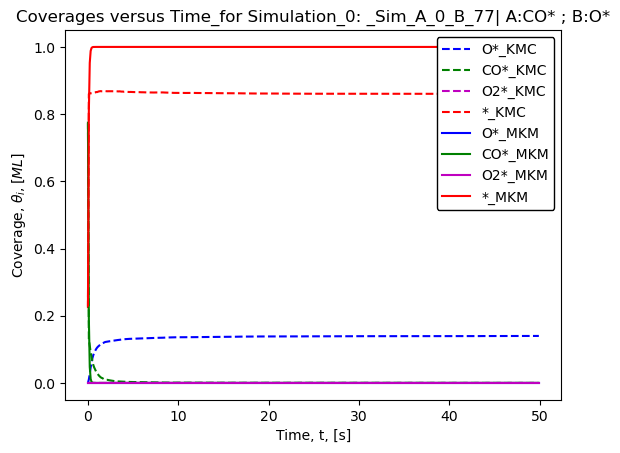

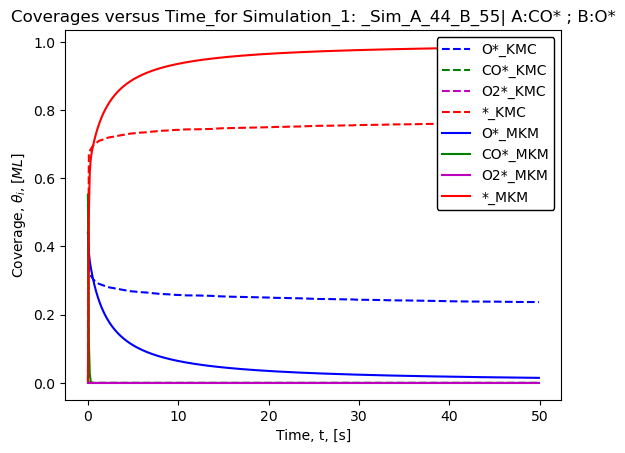

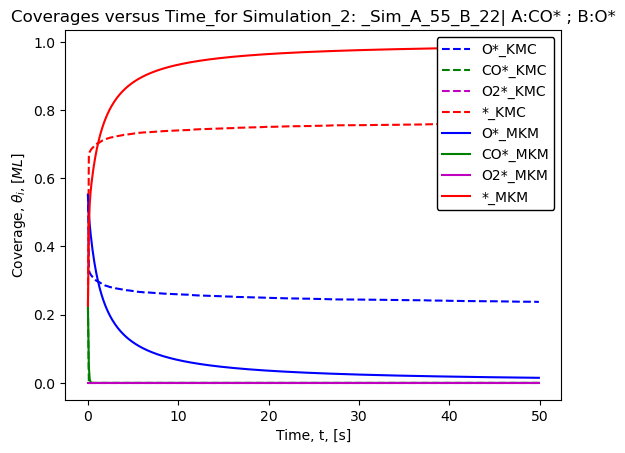

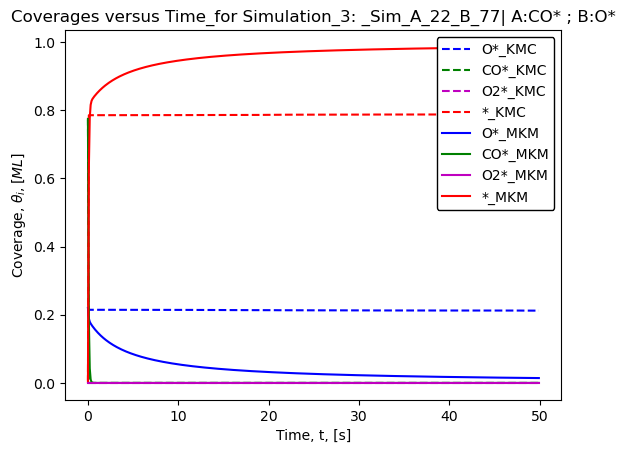

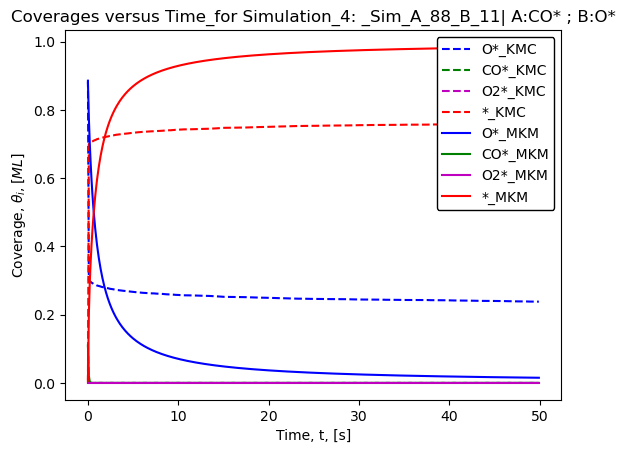

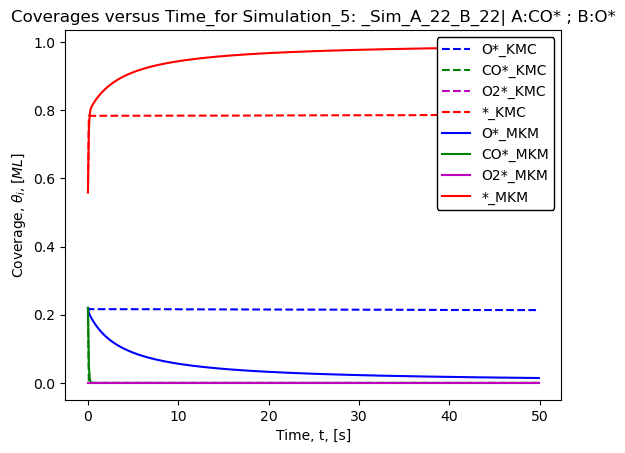

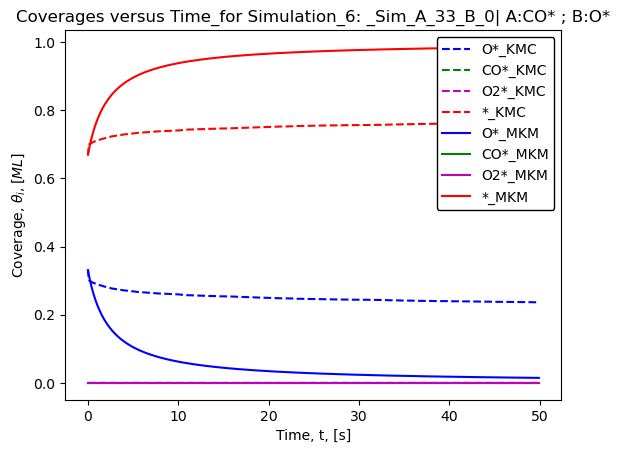

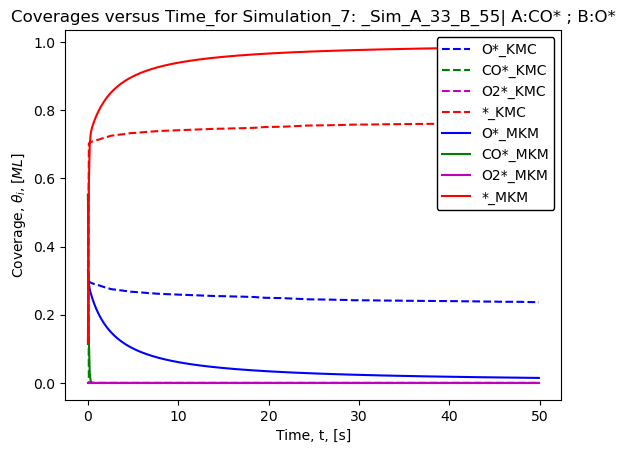

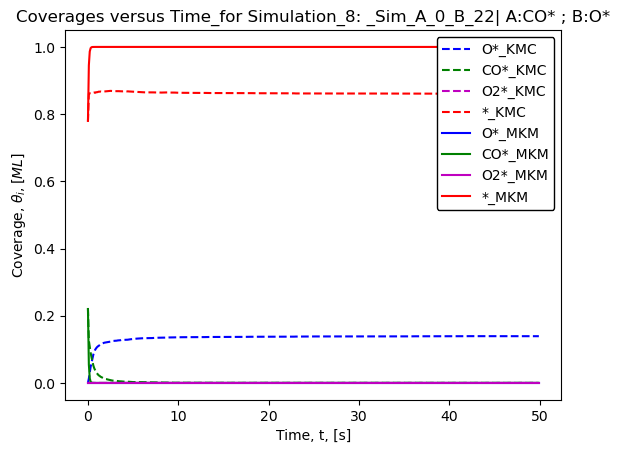

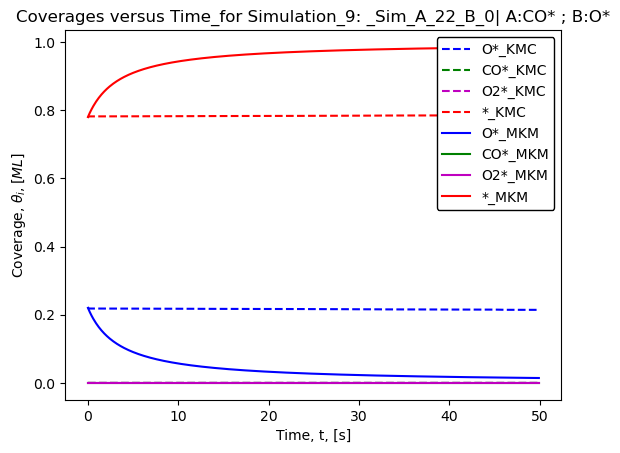

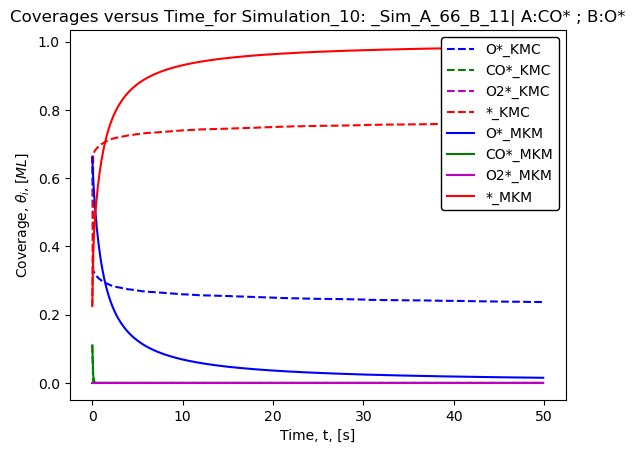

In [ ]:
%%time
#Part 1: Choose the feature of which you we will compare the k-opt values

# Comp = 'iRates'
Comp = 'Covg'
colors = ['b','g','m','r','c','y','k'] 

print('Comparison of KMC vs fitted-k MKM results for' + Comp)

#Part 2: Plot comparison results for fitting analysis
for i in np.arange(len(set(out_df['Sim_ndex']))): #For each simulation:
        #Extracting KMC results: ------------------------------------------------
        df = out_df.loc[out_df['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat = df[[col for col in df if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        Time = df['Time'].to_numpy()

        #Plotting KMC result : ------------------------------------------------          
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for i in np.arange(len(kmc_dat[0,:])):
            ax.plot(Time, kmc_dat[:,i],colors[i]+'--')
                        
        if Comp =='iRates':
            leg_nd = (o.iloc[0,Gspecies].tolist())
            ax.set_ylim([-0.2,0.2])
        elif Comp == 'Covg':
            leg_nd = (o.iloc[0,Sspecies].tolist())
            
        ax.set_xlabel('Time, t, [s]')
        if Comp =='iRates':
            ax.set_ylabel(r"Rates of Production, $R_i$")
            ax.set_title('Rates of production versus Time_ for Simulation_'+ df['Sim_ndex'].iloc[i] +': _'+df['Sim_names'].iloc[0]+'| A:CO* ; B:O*')
        elif Comp == 'Covg':
            ax.set_ylabel(r"Coverage, $\theta_i, [ML]$")
            ax.set_title('Coverages versus Time_for Simulation_'+ df['Sim_ndex'].iloc[i] +': _'+df['Sim_names'].iloc[0]+'| A:CO* ; B:O*')
        
        
        #Extracting MKM results: ------------------------------------------------
        mkm_dat = df[[col for col in df if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        Time = df['Time'].to_numpy()
            
            
        #Adding to the plot, MKM result : ------------------------------------------------     
        for i in np.arange(len(mkm_dat[0,:])):
            ax.plot(Time, mkm_dat[:,i],colors[i]+'-')
        
        #Plotting all the legends together
        ax.legend([f"{string}_KMC" for string in leg_nd]+[f"{string}_MKM" for string in leg_nd],fontsize=10, loc='upper right',facecolor='white', edgecolor ='black', framealpha=1)


In [ ]:
%%time
#Part 1: Choose the feature of which you we will compare the k-opt values

Comp = 'iRates'
# Comp = 'Covg'
colors = ['b','g','m','r','c','y','k'] 

print('Comparison of KMC vs fitted-k MKM results for' + Comp)

#Part 2: Plot comparison results for fitting analysis
for i in np.arange(len(set(out_df['Sim_ndex']))): #For each simulation:
        #Extracting KMC results: ------------------------------------------------
        df = out_df.loc[out_df['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat = df[[col for col in df if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        Time = df['Time'].to_numpy()

        #Plotting KMC result : ------------------------------------------------          
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for i in np.arange(len(kmc_dat[0,:])):
            ax.plot(Time, kmc_dat[:,i],colors[i]+'--')
                        
        if Comp =='iRates':
            leg_nd = (o.iloc[0,Gspecies].tolist())
            ax.set_ylim([-0.2,0.2])
        elif Comp == 'Covg':
            leg_nd = (o.iloc[0,Sspecies].tolist())
            
        ax.set_xlabel('Time, t, [s]')
        if Comp =='iRates':
            ax.set_ylabel(r"Rates of Production, $R_i$")
            ax.set_title('Rates of production versus Time_ for Simulation_'+ df['Sim_ndex'].iloc[i] +': _'+df['Sim_names'].iloc[0]+'| A:CO* ; B:O*')
        elif Comp == 'Covg':
            ax.set_ylabel(r"Coverage, $\theta_i, [ML]$")
            ax.set_title('Coverages versus Time_for Simulation_'+ df['Sim_ndex'].iloc[i] +': _'+df['Sim_names'].iloc[0]+'| A:CO* ; B:O*')
        
        
        #Extracting MKM results: ------------------------------------------------
        mkm_dat = df[[col for col in df if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        Time = df['Time'].to_numpy()
            
            
        #Adding to the plot, MKM result : ------------------------------------------------     
        for i in np.arange(len(mkm_dat[0,:])):
            ax.plot(Time, mkm_dat[:,i],colors[i]+'-')
            ax.set_ylim(bottom=-0.05, top=0.05)
        
        #Plotting all the legends together
        ax.legend([f"{string}_KMC" for string in leg_nd]+[f"{string}_MKM" for string in leg_nd],fontsize=10, loc='upper right',facecolor='white', edgecolor ='black', framealpha=1)


***
<a id="2.3"></a> 
## 2.C  Creating Features:
<a href="#top">Back to top</a>

<a id="2.3.2"></a> 
## 2.C.1  Percent difference
<a href="#top">Back to top</a>

$$ p_{diff} = \frac{|r_{MKM}-r_{KMC}|}{\frac{(r_{MKM}+r_{KMC})}{2}} $$

In [ ]:
rx,ry,rz = np.shape(data_KMC_dict['iRates'])
P_diff = np.zeros((rx,ry,rz)) 

In [ ]:
import math
MKM_values = data_MKM_dict['iRates']
KMC_values = data_KMC_dict['iRates']

for i in np.arange(rx):
    for j in np.arange(ry):
        for k in np.arange(rz):
            mkmr = KMC_values[i,j,k]
            kmcr = MKM_values[i,j,k]      
            #Preventing nan
            if float(mkmr) == 0:
                mkmr = 1e-20
            if float(kmcr) == 0:
                kmcr = 1e-20
            val = abs(mkmr-kmcr)/((mkmr+kmcr)/2) 
            P_diff[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

<a id="2.3.1"></a> 
## 2.C.2  Log ratio correction factor
<a href="#top">Back to top</a>

$$ corr_{fac} = ln\frac{r_{KMC}}{r_{MKM}}$$

In [ ]:
rx,ry,rz = np.shape(data_KMC_dict['iRates'])
Corr_fac = np.zeros((rx,ry,rz)) 

In [ ]:
import math
MKM_values = data_MKM_dict['iRates']
KMC_values = data_KMC_dict['iRates']

for i in np.arange(rx):
    for j in np.arange(ry):
        for k in np.arange(rz):
            num = KMC_values[i,j,k]
            den = MKM_values[i,j,k]
            #Preventing log(0)
            if float(num) == 0:
                num = 1e-20
            if float(den) == 0:
                den = 1e-20
                
            frac = num/den
            #Making sure ln is defined
            if float(frac) < 0: #(i.e the rates are either being calculated as consumed versus produced)
                frac = abs(frac)
                
            val = np.log(frac)
            Corr_fac[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

# Adding Descriptors/Correction features

In [ ]:
#Percent Diff
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['P_diff_'+spec] = pd.DataFrame(Tensor_To_Array(P_diff))[1+i]

#Log Correc
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['Corr_fac_'+spec] = pd.DataFrame(Tensor_To_Array(Corr_fac))[1+i]

In [ ]:
out_df

***
<a id="2.5"></a> 
## 2.E  Extracting Full X (Feature) and Y(Target) datasets
<a href="#top">Back to top</a>

In [ ]:
All_columns = out_df.columns.to_list()
target_columns = list(filter(lambda x: ('Corr') in x or ('P_diff') in x, All_columns))

input_columns = [colmn for colmn in All_columns if colmn not in target_columns]

In [ ]:
X_all = out_df[input_columns] #Ignoring the first two columns(index and simulation name)

In [ ]:
Y_all = out_df[['Sim_ndex','Sim_names']+target_columns]

In [ ]:
X_all

# Removing KMC columns

In [ ]:
string_to_filter = 'KMC_'

# Using the filter function to select columns containing the specified string and drop them
filtered_columns = X_all.filter(like=string_to_filter, axis=1)
X_all.drop(columns=filtered_columns.columns, inplace=True)
X_all

***
<a id="2.6"></a> 
## 2.F  Performing Train/Test X and Y Split datasets
<a href="#top">Back to top</a>

In [ ]:
import random
p_test = 0.2 #Percent test data
print('Percent of test data selected:',p_test*100,'%')


max_sim_number = int(X_all[input_columns[0]].iloc[-1]) #MAx_number of simulations present #Count is starting from 0
n_test_sim = int(p_test*max_sim_number) #Number of simulations being used as test
sim_nums = list(set(X_all['Sim_ndex'])) # List of unique simulation numbers

test_sims = random.sample(sim_nums,n_test_sim) #Random sim_numbers for testing


In [ ]:
test_sims

In [ ]:
X_test = X_all.loc[X_all['Sim_ndex'].isin(test_sims)]
Y_test = Y_all.loc[Y_all['Sim_ndex'].isin(test_sims)]

X_train = X_all[~X_all['Sim_ndex'].isin(test_sims)]
Y_train = Y_all[~Y_all['Sim_ndex'].isin(test_sims)]

In [ ]:
#Making sure no null values are present
P_diff = [string for string in All_columns if string.startswith("P_diff_")]#Extracting all different forms of P_diff
Y_all[['Sim_ndex'] +P_diff].info()

In [ ]:
#REMOVING THE SIM_NDEX AND SIM_NAMES COLUMNS\
X_test = X_test.drop(columns=['Sim_ndex','Sim_names'])
Y_test = Y_test.drop(columns=['Sim_ndex','Sim_names'])

X_train = X_train.drop(columns=['Sim_ndex','Sim_names'])
Y_train = Y_train.drop(columns=['Sim_ndex','Sim_names'])

In [ ]:
X_train

In [ ]:
Y_train.info()

In [ ]:
X_train

In [ ]:
Y_train

***
<a id="3"></a> 
## 3. MODELLING
<a href="#top">Back to top</a>

***
<a id="4"></a> 
## 4. Describing Possible Machine Learning Model Algorithms
<a href="#top">Back to top</a>

In [ ]:
def ML_model(algorithm="XGBoost", X_train = X_train, Y_train = Y_train):
    
    #XGBoost Algorithm
    #https://xgboost.readthedocs.io/en/stable/python/python_api.html
    if algorithm=="XGBoost":  
        import xgboost as xgb

        reg = xgb.XGBRegressor(booster='gbtree',    
                               n_estimators=1500,
                               objective='reg:squarederror',
                               max_depth=20,
                               learning_rate=0.01)
        reg.fit(X_train, Y_train,
                eval_set=[(X_train, Y_train)],
                verbose=False)
    
    #Artificial Neural Network
    #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
    elif algorithm=="ANN":
        from sklearn.neural_network import MLPRegressor
        No_H_nodes_per_layer = 64
        print('Number of Hidden layer nodes per layer : ',No_H_nodes_per_layer)
        No_H_layers = 3
        print('Number of Hidden layers: ',No_H_layers)

        hidden_layers = No_H_nodes_per_layer*np.ones(No_H_layers) 
        hidden_layer_sizes = tuple(tuple(int(item) for item in hidden_layers))
        reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                            activation='relu', 
                            solver='adam')
#                            ,random_state=42, 
#                             max_iter=300)

        reg.fit(X_train, Y_train)
    
    #K-Nearest Neighbor
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    elif algorithm=="KNN":
        from sklearn.neighbors import KNeighborsRegressor

        reg = KNeighborsRegressor(n_neighbors=200, weights='distance',p=2)
        reg.fit(X_train, Y_train)
    
    #RandomForest 
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
    elif algorithm=='RandomForest':
        from sklearn.ensemble import RandomForestRegressor
        
        reg = RandomForestRegressor(n_estimators=1000, random_state=42)

        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information
        
    elif algorithm=='DecisionTree':
        from sklearn import tree
        reg = tree.DecisionTreeRegressor()#criterion='poisson',max_depth=20,min_samples_leaf=10,min_samples_split=20
        
        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information

    return reg

***
<a id="5"></a> 
## 5. Selecting the Training Model
<a href="#top">Back to top</a>

In [54]:
import time
######### OPTIONS: 'XGBoost','ANN','KNN','RandomForest'#########
################################################################
ALGORITHM_NAME = "ANN"
################################################################

start_time = time.time()
reg = ML_model(algorithm = ALGORITHM_NAME)
end_time = time.time()

elapsed_time = end_time - start_time
print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")


Elapsed Model Training Time: 
 7184.149721860886 seconds 
 119.73582869768143 minutes


In [94]:
def normalized_rmse(y_true, y_pred, normalize = True):
    # Calculate RMSE
    rmse = np.zeros((1,np.shape(y_true)[1]))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    
    # Calculate the range of true values
    y_range = np.max(y_true, axis=0) - np.min(y_true, axis=0)
    
    # Calculate normalized RMSE
    nrmse = rmse / y_range
    if normalize == True:
        return nrmse
    else:
        return rmse

In [56]:
from main import *
def ML_Correction_Prediction_From_kMC(Test,Test_File_pre_Path = '../Test_Data_Lateral/Test_',to_plot = False, save_plots = False):
    TestNo = Test
    print('-------------------------------------------------------------------')
    print('Fitting Test No.' + TestNo, ':\n')
    Test_File_Name =Test_File_pre_Path+TestNo+'/KMC_NonDynamic_Data_iCovg_iRates_Test_'+TestNo+'.csv'


    ## Importing External/Experimental Data to be used in the model
    KMC_Data_EXP = pd.read_csv(Test_File_Name)
    KMC_Data_EXP_rates= KMC_Data_EXP.iloc[:,-n_gas_species:] #To be used to later to compare and asses ML prediction results



    Test_File_Name =Test_File_pre_Path+TestNo+'/KMC_NonDynamic_Data_iCovg_iRates_Test_'+TestNo+'.csv'
    # print('KMC Input Data:\n\n',KMC_Data_EXP.head())
    #Creating repeated init covs matrix to make up X_Input entry for ML
    test_data_ini_cov = KMC_Data_EXP.iloc[0,1:5].values
    test_data_time_interv = KMC_Data_EXP.iloc[:,0].values
    matrix_test_data_ini_cov = np.empty((len(test_data_time_interv),len(test_data_ini_cov)))
    for i in np.arange(len(test_data_time_interv)):
        matrix_test_data_ini_cov[i] = test_data_ini_cov


    Sim_Input_File_Path = Test_File_Name.rsplit('/',1)[0]+'/simulation_input.dat'
    Test_Simulation_Values = open(Sim_Input_File_Path, 'r').readlines()
    Test_Temperature = float(Test_Simulation_Values[5][24:31])
    
    Test_Total_Pressure =float(Test_Simulation_Values[6][24:38]) 
    
    Test_Gas_Spec_Names = list((str(Test_Simulation_Values[9][23:])).split())
    
    Test_Mol_Frac = [float(i) for i in Test_Simulation_Values[12][23:].split()]
    

    Test_Surface_Spec_Names = list((str(Test_Simulation_Values[15][23:])).split())+ ['*']

    ## 6.A Generating corresponding MF-MKModel
    MKM_test_inp = MKModel('Atomic_sw.csv','Stoich_sw.csv','Param_sw.csv')
    Tot_Pres = Test_Total_Pressure
    Mol_frac_O2 = Test_Mol_Frac[0]
    Mol_frac_CO = Test_Mol_Frac[1]
    Mol_frac_CO2 = Test_Mol_Frac[2]
    MKM_test_inp.set_rxnconditions(Pr=[(Tot_Pres*Mol_frac_O2),(Tot_Pres*Mol_frac_CO), Mol_frac_CO2]) #From KMC #Make sure it matches 02 CO CO2
    # MKM_test_inp.set_rxnconditions(Pr = list(float(i) for i in MKM.P) )
    MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))
    MKM_test_inp.ODE_Tolerances(Dplace=50,reltol=1e-8,abstol=1e-8)
    # MKM_test_inp.k = params #From fitting or external
    MKM_test_inp.k= MKM.k
    MKM_Covg_test_inp = np.zeros((len(test_data_time_interv),len(test_data_ini_cov))) 
    MKM_Rates_test_inp = np.zeros((len(test_data_time_interv),n_gas_species)) 

    MKM_test_inp.set_initial_coverages(init=test_data_ini_cov)

    Test_Surface_Spec_Names = list((str(Test_Simulation_Values[15][23:])).split())+ ['*']
    

    test_sola,_ = MKM_test_inp.solve_coverage(Tf_eval=test_data_time_interv,plot=False)
    MKM_Covg_test_inp = test_sola #Coverage profile matrix

    test_solb,_ = MKM_test_inp.solve_rate_production(Tf_eval=test_data_time_interv,plot=False)
    MKM_Rates_test_inp = test_solb[:,0:n_gas_species]


    Exp_surf_name = Test_Surface_Spec_Names #KMC_Data_EXP.columns.to_list()[1:n_surf_species+1]
    Exp_gas_name = Test_Gas_Spec_Names #[i[-2:] for i in KMC_Data_EXP.columns.to_list()[n_surf_species+1:]]

    Test_input = pd.DataFrame()

    #Adding initial coverages
    surf_names = Exp_surf_name
    for i in np.arange(n_surf_species):
        spec = surf_names[i]
        Test_input['Init_Covg_'+spec] = pd.DataFrame(matrix_test_data_ini_cov)[i]

    #Adding Time
    Test_input['Time'] = pd.DataFrame(test_data_time_interv)

    #Adding coverage profiles of surface species
    surf_names = Exp_surf_name
    for i in np.arange(n_surf_species):
        spec = surf_names[i]
        Test_input['MKM_Covg_'+spec] = pd.DataFrame(MKM_Covg_test_inp)[i]

    #Adding iRates profiles of gaseous species
    gs_names = (o.iloc[0,Gspecies].tolist())
    for i in np.arange(n_gas_species):
        spec = gs_names[i]
        Test_input['MKM_iRates_'+spec] = pd.DataFrame(MKM_Rates_test_inp)[i]


    #Helpful for XGBOOST readability
    Test_input['MKM_iRates_CO2'] = Test_input['MKM_iRates_CO2'].astype(float)
    Test_input['MKM_iRates_O2'] = Test_input['MKM_iRates_O2'].astype(float)
    Test_input['MKM_iRates_CO'] = Test_input['MKM_iRates_CO'].astype(float)

    Test_output = reg.predict(Test_input) #FITTING


    Pred_corr = Test_output[:,-len(Exp_gas_name):] #extracting correction factors  #O2 #CO #CO2


    #Calculating extracted ML predicted rates
    ML_Rates_pred = np.zeros((len(test_data_time_interv),len(Exp_gas_name)))  #O2, #CO, #CO2
    for i in np.arange(np.shape(ML_Rates_pred)[0]):
        for j in np.arange(np.shape(ML_Rates_pred)[1]):
            ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])


    from math import sqrt
    from sklearn.metrics import mean_squared_error
    #Calculating the root mean squared of the test set
    RMSE =  normalized_rmse(KMC_Data_EXP_rates, ML_Rates_pred, normalize = False) #RMSE
    NRMSE = normalized_rmse(KMC_Data_EXP_rates, ML_Rates_pred) #Normalized
    print('Root Mean Squared Error:\n',RMSE)
#     Test_RMSE_array.append(T_RMSE)

    #PLOTTING
    if to_plot == True:
        print('Test' + TestNo +' Temperature: ', Test_Temperature , ' K\n')
        
        print('Test ' + TestNo + ' Total Pressure: ', Test_Total_Pressure , ' bar\n')
        
        print('Test ' + TestNo + ' Gas Species: ', Test_Gas_Spec_Names , ' \n')
        
        print('Test ' + TestNo + ' Molar Fraction: ', Test_Mol_Frac , ' \n')
        
        print('Test ' + TestNo + ' Surface Species: ', Test_Surface_Spec_Names , ' \n')

        print('Test ' + TestNo + ' Initial Surface Coverage: ', test_data_ini_cov , ' \n')
    
    
        %matplotlib notebook
        import mpld3
        plt.figure(figsize = (8, 6))
        plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='O2_kMC')        
        plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='CO_kMC') 
        plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

        plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='O2_MKM')        
        plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='CO_MKM') 
        plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

        plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='O2_ML')        
        plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='CO_ML') 
        plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

        plt.xlabel('Time, s')
        plt.ylabel("Rates_production, $r$")
        plt.title('ML_rate_correction_Results_Test_'+TestNo )
        # plt.ylim([-0.004,0.004])
        plt.legend(fontsize=5, loc='best')
        if save_plots == True:
            mpld3.save_html(plt.gcf(), 'TOF plot Test_'+Test+'.html')        
        plt.show()
    #     import webbrowser
    #     webbrowser.open('TOF plot Test_'+Test+'.html')

        ## Parity Plotting:
        #Rates
        plt.figure()
        # Draw a y=x line
        plt.axline((0, 0), slope=1,color = 'k',linestyle='--')
        plt.plot(KMC_Data_EXP_rates.values[:,0],ML_Rates_pred[:,0],'r*',label='O2')
        plt.plot(KMC_Data_EXP_rates.values[:,1],ML_Rates_pred[:,1],'g*', label='CO')
        plt.plot(KMC_Data_EXP_rates.values[:,2],ML_Rates_pred[:,2],'b*', label='CO2')
        plt.xlabel(r'Rates_Test_'+TestNo+' (experimental)')
        plt.title('Parity Plot_Test_'+TestNo)
        plt.ylabel("Rates_Test_"+TestNo+" (fit)")
        # plt.ylim([-0.005,0.005])
        # plt.xlim([-0.005,0.005])
        plt.legend(loc='best')
        if save_plots == True:
            from plotly.offline import plot
            mpld3.save_html(plt.gcf(), 'Parity plot Test_'+Test+'.html') 
        plt.show()
    #        import webbrowser
    #     webbrowser.open('Parity plot Test_'+Test+'.html')
    return RMSE, NRMSE, np.mean(NRMSE)

In [57]:
Test_L = [16,17,18,19,20,21,23,24,25,26,27,28,29,30]
Test_NL = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

In [58]:
# Test_No = '16'
Lateral_Path = '../Test_Data_Lateral/Test_'
Non_Lateral_Path = '../../Input_data_KMC_Non_Lateral/Test_Data_Non_Lateral/Test_'

In [59]:
NRMSE_O2 = []
NRMSE_CO = []
NRMSE_CO2 = []
MNRMSE_LATERAL = []
Sim_paths = [Non_Lateral_Path,Lateral_Path]
Tests_Nos = [Test_NL,Test_L]
for i in np.arange(len(Sim_paths)):
    for j in np.arange(len(Tests_Nos[i])):
        _,NRMSE,MNRMSE = ML_Correction_Prediction_From_kMC(str(Tests_Nos[i][j]),Test_File_pre_Path=Sim_paths[i],save_plots=False)
        NRMSE_O2.append(NRMSE[0])
        NRMSE_CO.append(NRMSE[1])
        NRMSE_CO2.append(NRMSE[2])
        MNRMSE_LATERAL.append(MNRMSE)

-------------------------------------------------------------------
Fitting Test No.1 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.148513
R_CO     0.004905
R_CO2    0.004628
dtype: float64
-------------------------------------------------------------------
Fitting Test No.2 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.094737
R_CO     0.183020
R_CO2    0.108174
dtype: float64
-------------------------------------------------------------------
Fitting Test No.3 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     386621.100772
R_CO          0.312264
R_CO2         0.154438
dtype: float64
-------------------------------------------------------------------
Fitting Test No.4 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.865586
R_CO     0.654991
R_CO2    0.106432
dtype: float64
-------------------------------------------------------------------
Fitting Test No.5 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.148764
R_CO     0.004650
R_CO2    0.003187
dtype: float64
-------------------------------------------------------------------
Fitting Test No.6 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.104973
R_CO     0.004463
R_CO2    0.004320
dtype: float64
-------------------------------------------------------------------
Fitting Test No.7 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.372574
R_CO     0.311343
R_CO2    0.129510
dtype: float64
-------------------------------------------------------------------
Fitting Test No.8 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.035453
R_CO     0.424060
R_CO2    0.130076
dtype: float64
-------------------------------------------------------------------
Fitting Test No.9 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.038157
R_CO     0.184050
R_CO2    0.015820
dtype: float64
-------------------------------------------------------------------
Fitting Test No.10 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     1.233271e+03
R_CO     4.062700e+11
R_CO2    1.292994e-01
dtype: float64
-------------------------------------------------------------------
Fitting Test No.11 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     386620.930010
R_CO          0.223902
R_CO2         0.002100
dtype: float64
-------------------------------------------------------------------
Fitting Test No.12 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.924246
R_CO     0.584558
R_CO2    0.005810
dtype: float64
-------------------------------------------------------------------
Fitting Test No.13 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     2.884332
R_CO     0.391273
R_CO2    0.124517
dtype: float64
-------------------------------------------------------------------
Fitting Test No.14 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     1.233271e+03
R_CO     4.062700e+11
R_CO2    1.293184e-01
dtype: float64
-------------------------------------------------------------------
Fitting Test No.15 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     2.884380
R_CO     0.177984
R_CO2    0.014469
dtype: float64
-------------------------------------------------------------------
Fitting Test No.16 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.104899
R_CO     0.000657
R_CO2    0.000062
dtype: float64
-------------------------------------------------------------------
Fitting Test No.17 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.058790
R_CO     0.169712
R_CO2    0.000149
dtype: float64
-------------------------------------------------------------------
Fitting Test No.18 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     3.866212e+05
R_CO     1.450568e-02
R_CO2    4.275474e-07
dtype: float64
-------------------------------------------------------------------
Fitting Test No.19 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.968176
R_CO     0.088966
R_CO2    0.002693
dtype: float64
-------------------------------------------------------------------
Fitting Test No.20 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.075430
R_CO     0.000687
R_CO2    0.000038
dtype: float64
-------------------------------------------------------------------
Fitting Test No.21 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.074138
R_CO     0.000475
R_CO2    0.000064
dtype: float64
-------------------------------------------------------------------
Fitting Test No.23 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.059735
R_CO     0.174199
R_CO2    0.027499
dtype: float64
-------------------------------------------------------------------
Fitting Test No.24 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.054175
R_CO     0.169750
R_CO2    0.000178
dtype: float64
-------------------------------------------------------------------
Fitting Test No.25 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     1.233216e+03
R_CO     4.062700e+11
R_CO2    1.292114e-01
dtype: float64
-------------------------------------------------------------------
Fitting Test No.26 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     3.866211e+05
R_CO     1.450568e-02
R_CO2    4.275474e-07
dtype: float64
-------------------------------------------------------------------
Fitting Test No.27 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     0.961616
R_CO     0.098838
R_CO2    0.000232
dtype: float64
-------------------------------------------------------------------
Fitting Test No.28 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     2.932001
R_CO     0.215596
R_CO2    0.244984
dtype: float64
-------------------------------------------------------------------
Fitting Test No.29 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     1.233177e+03
R_CO     4.062700e+11
R_CO2    1.293184e-01
dtype: float64
-------------------------------------------------------------------
Fitting Test No.30 :

Mass is conserved. 



/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


Root Mean Squared Error:
 R_O2     2.924937
R_CO     0.218314
R_CO2    0.238779
dtype: float64


In [60]:
print('NRMSE_O2:\n',NRMSE_O2)
print('NRMSE_CO:\n',NRMSE_CO)
print('NRMSE_CO2:\n',NRMSE_CO2)
print('MNRMSE_LATERAL:\n',MNRMSE_LATERAL)

NRMSE_O2:
 [0.025408636970086648, 0.10752399741794592, 59992.42437537303, 0.3525461033884755, 0.025397315187948057, 0.01795777322439872, 0.21568111646960927, 26.13894746803956, 1.1435939049524593, 349717.64386866963, 35745.370093998674, 0.8174521338603511, 1329.099996071735, 2273164.9534737817, 1518.9970013174668, 0.11182759878561188, 0.04642716436666977, 76469.58972360188, 6.671183286528089, 0.017951368763658493, 0.07901171080618034, 0.046624474692719485, 0.047663554673509266, 986.7866264888848, 75577.48451493119, 3.112291261667614, 2.740498669396277, 589.3162038430107, 3.1722524232833873]
NRMSE_CO:
 [0.15193461370850678, 4.853859708682988, 0.07603229032263947, 0.04742801454418344, 0.1242078678454831, 0.13826439469600307, 0.16464398018439563, 0.11073556461062344, 17.85480012586382, 27080262403.91135, 0.04946908616963402, 0.04567816361751722, 0.11016477789912686, 27084180195.097702, 2.475931770397339, 0.05269016697927527, 0.022651187069680785, inf, 0.03888586398070791, 0.11009978860587

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_64723/1106055552.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))


-------------------------------------------------------------------
Fitting Test No.29 :

Mass is conserved. 

Root Mean Squared Error:
 R_O2     1.233177e+03
R_CO     4.062700e+11
R_CO2    1.293184e-01
dtype: float64
Test29 Temperature:  373.0  K

Test 29 Total Pressure:  0.5  bar

Test 29 Gas Species:  ['O2', 'CO', 'CO2']  

Test 29 Molar Fraction:  [0.67, 0.33, 0.0]  

Test 29 Surface Species:  ['O*', 'CO*', 'O2*', '*']  

Test 29 Initial Surface Coverage:  [0. 0. 0. 1.]  



<IPython.core.display.Javascript object>


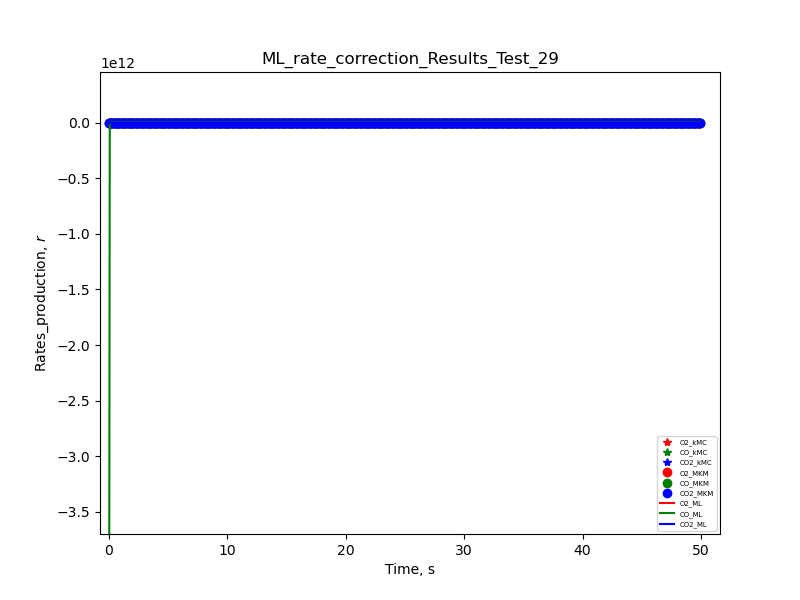

<IPython.core.display.Javascript object>


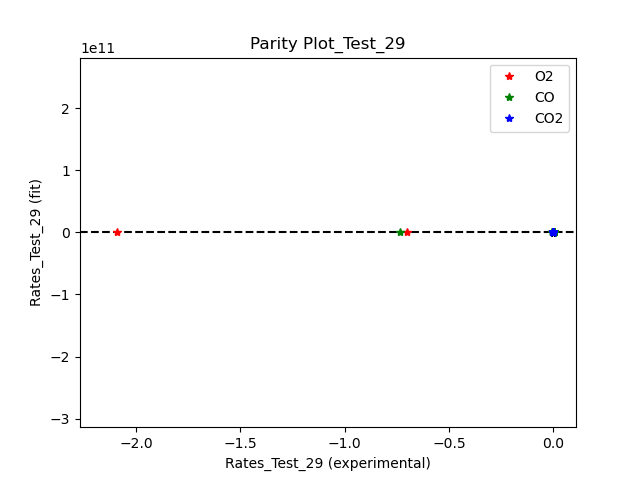

In [76]:
a,b,c = ML_Correction_Prediction_From_kMC('29',Test_File_pre_Path=Lateral_Path,to_plot=True)

In [80]:
a

R_O2     1.233177e+03
R_CO     4.062700e+11
R_CO2    1.293184e-01
dtype: float64

In [62]:
NRMSE

In [63]:
# Test_NL = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

In [64]:
RMSE_NL,NRMSE_NL = ML_Correction_Prediction_From_kMC('3',Test_File_pre_Path=Non_Lateral_Path,save_plots=False)

***
<a id="7"></a> 
## 7. Exploring and Evaluating possible ML options
<a href="#top">Back to top</a>
***

In [ ]:
# %%time
# #%matplotlib notebook
# import time
# from math import sqrt
# from sklearn.metrics import mean_squared_error

# algs = ['ANN','KNN','RandomForest','DecisionTree']
# rmse_vec = []
# for v in np.arange(len(algs)):
    
#     print("-"*50)
#     print('Algorithm:',algs[v],'\n')
    
#     tart_time = time.time()  
#     reg = ML_model(algorithm=algs[v])
#     end_time = time.time()

#     elapsed_time = end_time - start_time
#     print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")
    
#     Test_output = reg.predict(Test_input)

#     Pred_corr = Test_output[:,-3:] #extracting correction factors #CO #O2 #CO2
    
#     #Calculating extracted ML predicted rates
#     ML_Rates_pred = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2
#     for i in np.arange(np.shape(ML_Rates_pred)[0]):
#         for j in np.arange(np.shape(ML_Rates_pred)[1]):
#             ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])
    
#     #Calculating the root mean squared of the test set
#     rmse = sqrt(mean_squared_error(KMC_Data_EXP_rates, ML_Rates_pred))
#     print('\nRoot Mean Squared Error when using',algs[v],':\n',rmse)
#     rmse_vec.append(rmse)
    
#     plt.figure()
#     plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='O2_kMC')        
#     plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='CO_kMC') 
#     plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

#     plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='O2_MKM')        
#     plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='CO_MKM') 
#     plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

#     plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='O2_ML')        
#     plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='CO_ML') 
#     plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

#     plt.xlabel('Time, s')
#     plt.ylabel("Rates_production, $r$")
#     plt.title('Algorithm: {}'.format(algs[v]))
#     plt.legend(fontsize=5, loc='best')

#     plt.show()

In [ ]:
# print("The ML model giving the smallest rmse of", rmse_vec[np.argmin(rmse_vec)],"is : \n",algs[np.argmin(rmse_vec)]) 